In [29]:
import torch

import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [30]:
num_classes = 25
##########################################################
# 调整的参数
picture_size = 224
epoch_test = 100
batch_size_test = 64
learn_rate_tes = 0.004

'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                     # 输入图片的shape
    "class_dim": 25,                                 # 分类数
    "src_path":"./archive_train.zip",   # 原始数据集路径
    "target_path":"./data/dataset",     # 要解压的路径 
    "train_list_path": "./train.txt",                # train_data.txt路径
    "eval_list_path": "./eval.txt",                  # eval_data.txt路径
    "label_dict":{},                                 # 标签字典
    "num_epochs":epoch_test,                                 # 训练轮数
    "train_batch_size": batch_size_test,                          # 批次的大小
    "learning_strategy": {                           # 优化函数相关的配置
        "lr": learn_rate_tes                                  # 超参数学习率
    }
}

In [31]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''
    if(not os.path.isdir(target_path)):
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")

In [32]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    # 获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # 存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    class_label=0
    i = 0

    for class_dir in class_dirs:
        path = os.path.join(data_list_path,class_dir)
        # 获取所有图片
        img_paths = os.listdir(path)
        for img_path in img_paths:                                        # 遍历文件夹下的每个图片
            i += 1
            name_path = os.path.join(path,img_path)                       # 每张图片的路径
            if i % 10 == 0:
                eval_list.append(name_path + "\t%d" % class_label + "\n")
            else:
                trainer_list.append(name_path + "\t%d" % class_label + "\n")

        train_parameters['label_dict'][str(class_label)]=class_dir
        class_label += 1

    #乱序  验证集
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image)

            #乱序训练集【补充代码】       
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f:
        for trainer_image in trainer_list:
            f.write(trainer_image)


    print ('生成数据列表完成！')

In [33]:
# 参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

# 解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f:
    f.seek(0)
    f.truncate()
with open(eval_list_path, 'w') as f:
    f.seek(0)
    f.truncate()

#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

文件已解压
生成数据列表完成！


In [34]:
class Reader(object):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 

        img = img.resize((picture_size,picture_size), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [35]:
#训练数据加载
train_dataset = Reader('./',mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle=True)
# train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)

#测试数据加载
eval_dataset = Reader('./',mode='eval')
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size = 8, shuffle=False)
# eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [36]:
train_dataset.print_sample(200)
print(train_dataset.__len__())

eval_dataset.print_sample(0)
print(eval_dataset.__len__())

print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 ./data/dataset\Jade\jade_0.jpg 	标签值 13
730
文件名 ./data/dataset\Alexandrite\alexandrite_27.jpg 	标签值 0
81
(3, 224, 224)
(1,)


In [37]:
Batch=0
Batchs=[]
all_train_accs=[]

def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

In [38]:
#model.py

import torch.nn as nn
import torch

#18/34
class BasicBlock(nn.Module):
    expansion = 1 #每一个conv的卷积核个数的倍数

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):#downsample对应虚线残差结构
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)#BN处理
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x #捷径上的输出值
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

#50,101,152
class Bottleneck(nn.Module):
    expansion = 4#4倍

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion,#输出*4
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=1000, include_top=True):#block残差结构 include_top为了之后搭建更加复杂的网络
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)

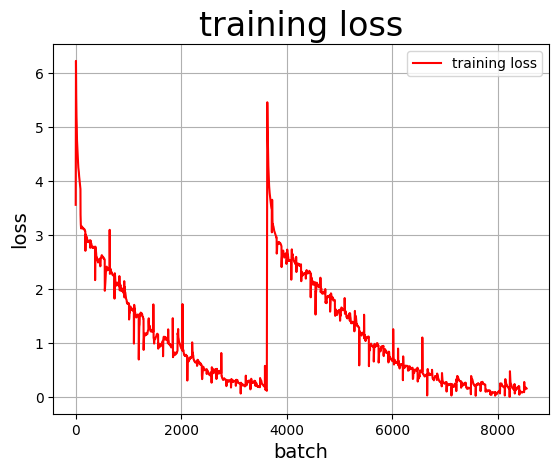

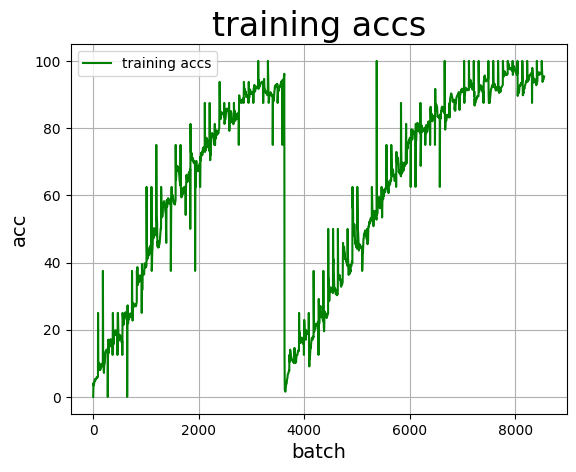

Loss: 3.611 | Acc: 0.000% (0/8)
Loss: 5.621 | Acc: 4.167% (2/48)
Loss: 5.110 | Acc: 3.409% (3/88)
Loss: 4.716 | Acc: 3.906% (5/128)
Loss: 4.432 | Acc: 5.357% (9/168)
Loss: 4.330 | Acc: 4.808% (10/208)
Loss: 4.210 | Acc: 5.242% (13/248)
Loss: 4.140 | Acc: 4.861% (14/288)
Loss: 4.072 | Acc: 4.573% (15/328)
Loss: 3.997 | Acc: 4.348% (16/368)
Loss: 3.955 | Acc: 4.167% (17/408)
Loss: 3.894 | Acc: 4.464% (20/448)
Loss: 3.841 | Acc: 4.303% (21/488)
Loss: 3.799 | Acc: 4.167% (22/528)
Loss: 3.749 | Acc: 4.225% (24/568)
Loss: 3.703 | Acc: 4.770% (29/608)
Loss: 3.669 | Acc: 5.401% (35/648)
Loss: 3.626 | Acc: 5.378% (37/688)
Loss: 3.593 | Acc: 5.357% (39/728)
Loss: 3.156 | Acc: 0.000% (0/8)
Loss: 3.082 | Acc: 8.333% (4/48)
Loss: 3.140 | Acc: 6.818% (6/88)
Loss: 3.111 | Acc: 6.250% (8/128)
Loss: 3.097 | Acc: 6.548% (11/168)
Loss: 3.042 | Acc: 8.173% (17/208)
Loss: 3.062 | Acc: 7.258% (18/248)
Loss: 3.042 | Acc: 7.292% (21/288)
Loss: 3.026 | Acc: 7.317% (24/328)
Loss: 3.021 | Acc: 8.152% (30/368)
Lo

In [41]:
model = resnet34(num_classes=num_classes, include_top=True)

#训练
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate_tes)

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for pass_num in range(train_parameters['num_epochs']):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.squeeze()).sum().item()

            print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

            Batch = Batch + 1
            Batchs.append(Batch)
            all_train_loss.append(train_loss)
            all_train_accs.append(100.*correct/total)

draw_train_loss(Batchs, all_train_loss)
draw_train_acc(Batchs, all_train_accs)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(eval_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.squeeze()).sum().item()

            print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

for epoch in range(epoch_test):
    train(epoch)

#保存模型
torch.save(model, 'model.pth')

#加载模型
model = torch.load('model.pth')

#测试
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(eval_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets.squeeze()).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

#预测
import matplotlib.pyplot as plt
import numpy as np

def predict(model, image_path):
    model.eval()
    img = Image.open(image_path)
    img = img.resize((picture_size,picture_size), Image.BILINEAR)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1)) / 255
    img = torch.Tensor(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    outputs = model(img)
    _, predicted = outputs.max(1)
    return predicted

#测试
image_path = './data/dataset/0/0.jpg'
predicted = predict(model, image_path)
print('Predicted:', train_parameters['label_dict'][str(predicted.item())])

In [25]:
# model = eval('resnet34')(num_classes=num_classes, include_top=True)
# model.train() # 训练模式
# cross_entropy = torch.nn.CrossEntropyLoss() #损失函数
# # cross_entropy = paddle.nn.CrossEntropyLoss()
# opt = torch.optim.SGD(model.parameters(), lr=train_parameters['learning_strategy']['lr']) #优化器
# # opt=paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'],\
# #                                                     parameters=model.parameters())

# print("Label shape:", label.shape)

# epochs_num=train_parameters['num_epochs'] #迭代次数
# for pass_num in range(train_parameters['num_epochs']):
#     for batch_id,data in enumerate(train_loader):
#     # for batch_id,data in enumerate(train_loader()):
#         image = data[0]
#         label = data[1]
#         # 如果是googlenet用第二行代码，虽然tensor结构中有shape参数，但是后续代码依然无法访问
#         # 报错 ： 'tuple' object has no attribute 'shape
#         predict = model(image)[0] #数据传入model
#         # predict = model(image)

#         # print(type(predict))
#         # print()
#         # print(type(label))
#         # print(predict)

#         # 假设label需要调整
#         label = label.argmax(dim=1)

#         loss=cross_entropy(predict,label)
#         acc = (predict.argmax(1) == label).float().mean()
#         # acc=paddle.metric.accuracy(predict,label)#计算精度
#         if batch_id!=0 and batch_id%5==0:
#             Batch = Batch+5 
#             Batchs.append(Batch)
#             all_train_loss.append(loss.numpy()[0])
#             all_train_accs.append(acc.numpy()[0]) 
#             print("epoch:{},step:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))        
#         loss.backward()       
#         opt.step()
#         opt.clear_grad()   #opt.clear_grad()来重置梯度

# # 保存模型
# torch.save(model.state_dict(), './ResNet.pth')  
# # paddle.save(model.state_dict(),function_name)#保存模型
# draw_train_acc(Batchs,all_train_accs)
# draw_train_loss(Batchs,all_train_loss)

Label shape: torch.Size([8, 1])


RuntimeError: size mismatch (got input: [25], target: [8])